In [149]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import opendp.prelude as dp
dp.enable_features("contrib")
dp.enable_features("floating-point")

In [206]:
for i in range(len(budget)):
    threshold = 2*(np.log(2/budget[1][1]))/(budget[i][0]) + 1/size
    print(budget[i][0], threshold)

0.5 64.85396985349429
1.0 32.426985108549594
1.5 21.617990193568026
2.0 16.213492736077242
2.5 12.970794261582775
3.0 10.808995278586462
3.5 9.26485314787481
4.0 8.10674654984107
4.5 7.205996973592606
5.0 6.485397312593835


# County Level

In [151]:
agg_county_data_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/agg_commute_county_level_all.csv")
county_data_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/commute_county_level_all.csv")

In [152]:
county_categories = agg_county_data_df['County_commute'].unique()
len(county_categories) # MUST TAKE FROM DATA WHERE CATEGORIES CAN HAVE COUNT 0 ie.not where each individual is row

1085

In [153]:
col_names = ["County_commute","County_Origin","County_Destination"]
size = len(county_data_df) #Number of individuals in dataset
county_categories = list(county_categories) #Number of possible categories 


In [154]:
with open('commute_county_level_all.csv') as input_data:
    county_data = input_data.read()

In [155]:
def plot_histogram(sensitive_counts, released_counts):
    """Plot a histogram that compares true data against released data"""
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    #plt.ylim([0,20000])
    
    tick_spacing = 1.
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    #plt.xlim(0,1084)
    width = .4

    ax.bar(list([x+width for x in range(0, len(sensitive_counts))]), sensitive_counts, width=width, label='True Value')
    ax.bar(list([x+2*width for x in range(0, len(released_counts))]), released_counts, width=width, label='DP Value')

    ax.legend()
    plt.xticks([])  
    plt.title('Histogram of Counts after Stability Histogram for County Level Commute')
    plt.xlabel('Commute')
    plt.ylabel('Count')
    plt.show()

In [156]:
max_influence = 2
epsilon = np.arange(0.5,5.5, 0.5)
delta = 1/(2*size)
budget = [(e, delta) for e in epsilon]

In [157]:
col_names = ["County_commute","County_Origin","County_Destination"]

histogram = (
    dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
    dp.t.make_select_column(key="County_commute", TOA=str) >>
    # Compute counts for each of the categories
    dp.t.then_count_by_categories(categories=county_categories)
)

county_sensitive_counts = histogram(county_data)

In [158]:
preprocess = (
    dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
    dp.t.make_select_column(key="County_commute", TOA=str) >>
    dp.t.then_count_by(MO=dp.L1Distance[float], TV=float))

In [159]:

def as_array(data):
    return [data.get(k, 0) for k in county_categories]

In [160]:
# empty dictionary
all_county_released_count_before = []
all_county_released_counts = []
all_county_elapsed_time = []

for epsilon in range(len(budget)):
    threshold = 2*(np.log(2/budget[1][1]))/(budget[epsilon][0]) + 1/size
    scale = max_influence/budget[epsilon][0]
    noisy_histogram = preprocess >> dp.m.then_base_laplace_threshold(scale=scale, threshold=threshold)

    sensitive_counts = histogram(county_data)

    start_time = time.time()
    released_counts = noisy_histogram(county_data)
    end_time = time.time()

    elapsed_time = end_time - start_time
    all_county_elapsed_time.append(elapsed_time)

    # postprocess to make the results easier to compare
    postprocessed_counts = {k: round(v) for k, v in released_counts.items()}

    all_county_released_count_before.append(postprocessed_counts)

#all_county_released_counts are not ordered. 
# https://docs.opendp.org/en/stable/examples/histograms.html#Private-histogram-via-make_count_by-and-make_base_laplace_threshold\n
#Corrects order so it can be compared to the true counts
for i in range(len(all_county_released_count_before)):
    released_counts = as_array(all_county_released_count_before[i])
    all_county_released_counts.append(released_counts)


In [220]:
county_stability_dp_df = pd.DataFrame(county_categories, columns = ['County Level Commute'])
county_stability_dp_df['True Count'] =  county_sensitive_counts[:-1]
for i, level in enumerate(budget):
    county_stability_dp_df[f'Privacy {level[0]}'] = all_county_released_counts[i]

#Save dataset
#county_stability_dp_df.to_csv('county_stability_dp_df.csv', sep=',', index=False, encoding='utf-8')

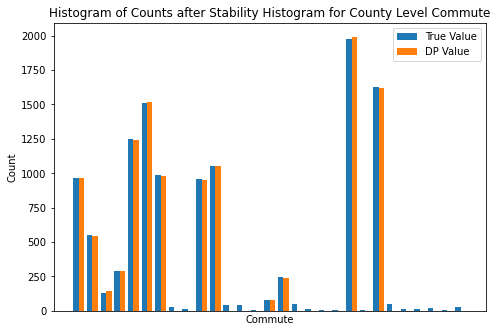

In [162]:
plot_histogram(sensitive_counts[1:30], all_county_released_counts[0][1:30])

In [163]:
def calculate_rmse(predicted_values, actual_values):    
    # Calculate the squared differences
    squared_diffs = np.square(np.array(predicted_values) - np.array(actual_values))
    
    # Calculate the mean of squared differences
    mean_squared_diff = np.mean(squared_diffs)
    
    # Take the square root to get RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse


In [164]:
len(budget)

10

In [165]:
all_county_rmse  =[]
for released_count in range(len(budget)):
    rmse = calculate_rmse(all_county_released_counts[released_count], county_sensitive_counts[:-1])
    all_county_rmse.append(rmse)


In [166]:
all_county_rmse
# [5.740630514993751,
#  2.8543765409959523,
#  1.8516401995451028,
#  1.4785719851286827,
#  1.1121449363491274,
#  0.9576276370511868,
#  0.8688145427405203,
#  0.7298759442598561,
#  0.637535577754862,
#  0.6124664948985143]

[21.073997344009026,
 10.292048740707848,
 6.595976989225805,
 4.903492595215823,
 3.5535404555999155,
 2.9068487379382946,
 2.2890241013160018,
 1.8464063988899495,
 1.4844819419395778,
 1.207885000782445]

In [167]:
epsilons = [budget[i][0] for i in range(len(budget))]

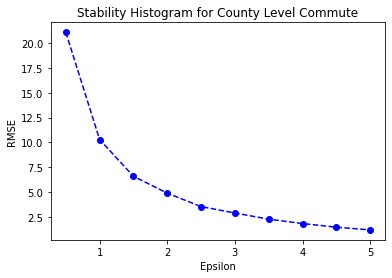

In [168]:
plt.plot(epsilons, all_county_rmse, 'bo')
plt.plot(epsilons, all_county_rmse, 'b--')
plt.xlabel('Epsilon')
plt.ylabel('RMSE')  
plt.title('Stability Histogram for County Level Commute')
#plt.savefig("Stability Histogram for County Level Commute")

In [169]:
#Maximum error 
#FIX AS SENSTIVE COUNTS HAS ONE EXTRA COUNT??
all_county_max_count_difference = []
all_county_max_count_difference_index = []
for released_count in range(len(budget)):
    max_county_count_difference = max(abs(all_county_released_counts[released_count][idx] - county_sensitive_counts[idx]) for idx in range(len(county_sensitive_counts)-1))
    all_county_max_count_difference.append(max_county_count_difference)
    county_max_count_difference_index = [idx for idx in range(len(county_sensitive_counts)-1) if abs(all_county_released_counts[released_count][idx] - county_sensitive_counts[idx]) == max_county_count_difference]
    all_county_max_count_difference_index.append(county_max_count_difference_index)


In [170]:
all_county_max_count_difference
#[80, 50, 32, 22, 17, 16]
all_county_max_count_difference_index
# [[391, 1017],
#  [45],
#  [866],
#  [661, 999],
#  [27, 194, 426, 432, 590, 652, 719, 839, 895],
#  [160, 240, 411]]

[[878],
 [206],
 [306],
 [89, 119, 805],
 [533, 1043],
 [166, 270, 1069],
 [720],
 [313],
 [623],
 [691]]

In [171]:
county_mean_time  = np.mean(all_county_elapsed_time)
county_mean_time # in seconds 
#4.642084693908691

4.576414179801941

In [172]:
all_county_elapsed_time

# [4.561943054199219,
#  4.480342864990234,
#  4.566525220870972,
#  4.473005056381226,
#  4.378741979598999,
#  4.460415840148926,
#  5.004343032836914,
#  5.07985782623291,
#  4.909744024276733,
#  4.505928039550781]

[4.28945779800415,
 4.255159139633179,
 4.267471790313721,
 4.392210245132446,
 5.33995509147644,
 4.342015981674194,
 5.126721143722534,
 4.35213303565979,
 4.8724448680877686,
 4.5265727043151855]

# ED Level

In [173]:
agg_ed_data_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/agg_commute_ed_level_all.csv")
ed_data_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/commute_ed_level_all.csv")

In [174]:
ed_categories = agg_ed_data_df['ED_Commute'].unique()
len(ed_categories) # MUST TAKE FROM DATA WHERE CATEGORIES CAN HAVE COUNT 0 ie.not where each individual is row

8699658

In [175]:
col_names = ["ED_commute","ED_Origin","ED_Destination"]
size = len(ed_data_df) #Number of individuals in dataset
ed_categories = list(ed_categories) #Number of possible categories 

In [176]:
with open('commute_ed_level_all.csv') as input_data:
    ed_data = input_data.read()

In [177]:
len(budget)

10

In [178]:
col_names = ["ED_commute","ED_Origin","ED_Destination"]

histogram = (
    dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
    dp.t.make_select_column(key="ED_commute", TOA=str) >>
    # Compute counts for each of the categories
    dp.t.then_count_by_categories(categories=ed_categories)
)

ed_sensitive_counts = histogram(ed_data)



In [179]:
def as_array(data):
    return [data.get(k, 0) for k in ed_categories]

In [180]:
# empty dictionary
all_ed_released_counts_before = []
all_ed_released_counts = []
all_ed_elapsed_time = []

for epsilon in range(len(budget)):
    scale = max_influence/budget[epsilon][0]
    threshold = 2*(np.log(2/budget[1][1]))/(budget[epsilon][0]) + 1/size
    noisy_histogram = preprocess >> dp.m.then_base_laplace_threshold(scale=scale, threshold=threshold)

    start_time = time.time()
    released_counts = noisy_histogram(ed_data)
    end_time = time.time()
    elapsed_time = end_time - start_time
    all_ed_elapsed_time.append(elapsed_time)

    # postprocess to make the results easier to compare
    postprocessed_counts = {k: round(v) for k, v in released_counts.items()}
    all_ed_released_counts_before.append(postprocessed_counts)

    print(epsilon)

for i in range(len(all_ed_released_counts_before)):
    released_counts = as_array(all_ed_released_counts_before[i])
    all_ed_released_counts.append(released_counts)



0
1
2
3
4
5
6
7
8
9


In [221]:
ed_stability_dp_df = pd.DataFrame(ed_categories, columns = ['ED Level Commute'])
ed_stability_dp_df['True Count'] =  ed_sensitive_counts[:-1]
for i, level in enumerate(budget):
    ed_stability_dp_df[f'Privacy {level[0]}'] = all_ed_released_counts[i]

#Save dataset
#ed_stability_dp_df.to_csv('ed_stability_dp_df.csv', sep=',', index=False, encoding='utf-8')

In [182]:
ed_stability_dp_df

,ED Level Commute,True Count,Privacy 0.5,Privacy 1.0,Privacy 1.5,Privacy 2.0,Privacy 2.5,Privacy 3.0,Privacy 3.5,Privacy 4.0,Privacy 4.5,Privacy 5.0
0,Carlow Urban-Carlow Urban,680,681,679,680,678,680,680,680,680,679,680
1,Carlow Urban-Graigue Urban,12,0,0,0,0,0,12,13,12,11,12
2,Carlow Urban-Hacketstown,8,0,0,0,0,0,0,0,9,0,9
3,Carlow Urban-Agha,2,0,0,0,0,0,0,0,0,0,0
4,Carlow Urban-Ballinacarrig,10,0,0,0,0,0,11,10,11,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...
8699653,Tullycorbet-Fánaid Thiar,0,0,0,0,0,0,0,0,0,0,0
8699654,Tullycorbet-Loch Caol,0,0,0,0,0,0,0,0,0,0,0
8699655,Tullycorbet-Feddyglass,0,0,0,0,0,0,0,0,0,0,0
8699656,Tullycorbet-Drummully,0,0,0,0,0,0,0,0,0,0,0


In [183]:
all_ed_rmse  =[]
for released_count in range(len(budget)):
    rmse = calculate_rmse(all_ed_released_counts[released_count], ed_sensitive_counts[:-1])
    all_ed_rmse.append(rmse)


In [184]:
all_ed_rmse
# [0.8112421350712523,
#  0.4290737100962413,
#  0.30024163249855496,
#  0.2334712175553153,
#  0.19252994309004093,
#  0.16566112263687102,
#  0.14506605594191427,
#  0.1290534487593263,
#  0.11765756586678351,
#  0.10756658303402995]

[1.8976176693593578,
 1.1891233413833633,
 0.8841803378105298,
 0.7160732933212272,
 0.6099883410733823,
 0.5350746984361697,
 0.481082012322305,
 0.43836290526748123,
 0.4042019063693748,
 0.37430332453876797]

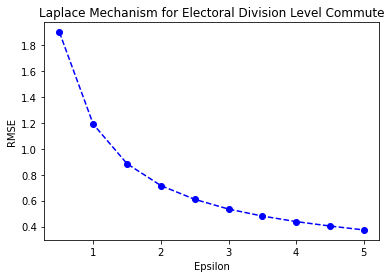

In [185]:
plt.plot(epsilons, all_ed_rmse, 'bo')
plt.plot(epsilons, all_ed_rmse, 'b--')
plt.xlabel('Epsilon')
plt.ylabel('RMSE')  
plt.title('Laplace Mechanism for Electoral Division Level Commute')
#plt.savefig("Laplace Mechanism for Electoral Division Level Commute")


In [186]:
#Maximum error 
all_ed_max_count_difference = []
all_ed_max_count_difference_index = []
for released_count in range(len(budget)):
    max_ed_count_difference = max(abs(all_ed_released_counts[released_count][idx] - ed_sensitive_counts[idx]) for idx in range(len(ed_sensitive_counts)-1))
    all_ed_max_count_difference.append(max_ed_count_difference)
    ed_max_count_difference_index = [idx for idx in range(len(ed_sensitive_counts)-1) if abs(all_ed_released_counts[released_count][idx] - ed_sensitive_counts[idx]) == max_ed_count_difference]
    all_ed_max_count_difference_index.append(ed_max_count_difference_index)


In [187]:
all_ed_max_count_difference
#[57, 32, 21, 16, 12, 10, 10, 8, 7, 6]
#all_ed_max_count_difference_index
# [[7890592],
#  [8426434],
#  [1638498],
#  [573781],
#  [691995, 3917674],
#  [5692415, 7269616],
#  [704791, 4168329, 4707089],
#  [5636043],
#  [2651429, 6328040],
#  [2327384, 2887713, 5594075, 5839875]]

[84, 44, 30, 22, 19, 16, 13, 11, 10, 10]

In [188]:
all_county_rmse_stability = [5.740630514993751,
 2.8543765409959523,
 1.8516401995451028,
 1.4785719851286827,
 1.1121449363491274,
 0.9576276370511868,
 0.8688145427405203,
 0.7298759442598561,
 0.637535577754862,
 0.6124664948985143]

all_ed_rmse_stability = [0.8112421350712523,
 0.4290737100962413,
 0.30024163249855496,
 0.2334712175553153,
 0.19252994309004093,
 0.16566112263687102,
 0.14506605594191427,
 0.1290534487593263,
 0.11765756586678351,
 0.10756658303402995]

all_ed_rmse_laplace = [4.004447500736218,
 1.9916422676485341,
 1.3143374744514225,
 0.9692345208476857,
 0.7582231225978382,
 0.6154841266020571,
 0.5108062113973159,
 0.43127549739811655,
 0.36823690510706764,
 0.31644289971986156]

all_county_rmse_laplace = [5.454735891535798,
 2.8549978793940256,
 1.7849380054335928,
 1.283124639222163,
 1.0707048331725255,
 0.8209952187261937,
 0.7270110863703116,
 0.5876256184028356,
 0.5059498661280492,
 0.40937449478410615]



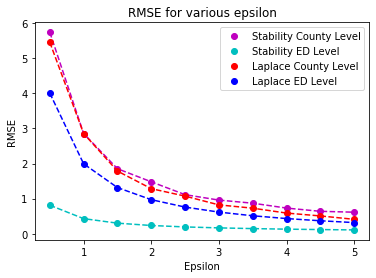

In [207]:
plt.plot(epsilons, all_county_rmse_stability, 'mo', label='Stability County Level')
plt.plot(epsilons, all_county_rmse_stability, 'm--')

plt.plot(epsilons, all_ed_rmse_stability, 'co', label='Stability ED Level')
plt.plot(epsilons, all_ed_rmse_stability, 'c--')

plt.plot(epsilons, all_county_rmse_laplace, 'ro', label='Laplace County Level')
plt.plot(epsilons, all_county_rmse_laplace, 'r--')

plt.plot(epsilons, all_ed_rmse_laplace, 'bo', label='Laplace ED Level')
plt.plot(epsilons, all_ed_rmse_laplace, 'b--')




plt.xlabel('Epsilon')
plt.ylabel('RMSE')  
plt.title('RMSE for various epsilon')
plt.legend(loc="upper right")
plt.savefig("RMSE for various epsilon")

In [190]:
all_ed_elapsed_time
# [21.485202312469482,
#  17.957573175430298,
#  18.45694899559021,
#  17.809370040893555,
#  18.68554186820984,
#  19.02080488204956,
#  18.262876987457275,
#  18.726460218429565,
#  17.495272159576416,
#  16.858014822006226]

[21.485202312469482,
 17.957573175430298,
 18.45694899559021,
 17.809370040893555,
 18.68554186820984,
 19.02080488204956,
 18.262876987457275,
 18.726460218429565,
 17.495272159576416,
 16.858014822006226]

In [191]:
ed_mean_time  = np.mean(all_ed_elapsed_time)
ed_mean_time # in seconds 
#18.475806546211242


18.475806546211242

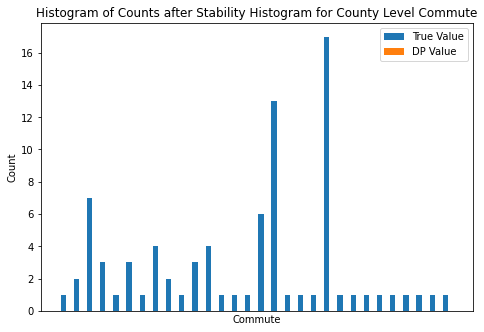

In [192]:
plot_histogram(ed_sensitive_counts[100:130], all_ed_released_counts[0][100:130])
#plt.savefig("Histogram of Counts after Laplace Mechanism for ED")

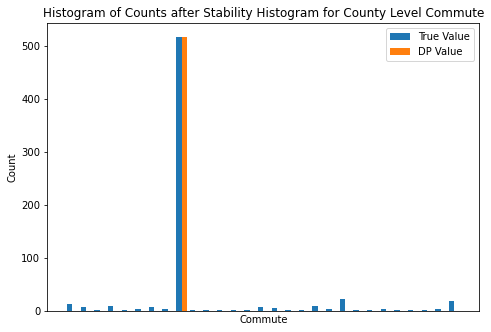

In [193]:
plot_histogram(ed_sensitive_counts[1:30], all_ed_released_counts[0][1:30])


# Analysis

In [222]:
county_stability_dp_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/county_stability_dp_df.csv")
ed_stability_dp_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/ed_stability_dp_df.csv")

In [223]:
ordered_county_stability_dp_df= county_stability_dp_df.sort_values(by=['True Count'], ascending=False)
county_true_count_list = ordered_county_stability_dp_df['True Count'].to_list()
county_epsilon05_list = ordered_county_stability_dp_df['Privacy 0.5'].to_list()

In [224]:
ordered_county_stability_dp_df

,County Level Commute,True Count,Privacy 0.5,Privacy 1.0,Privacy 1.5,Privacy 2.0,Privacy 2.5,Privacy 3.0,Privacy 3.5,Privacy 4.0,Privacy 4.5,Privacy 5.0
36,Dublin City-Dublin City,218860,218838,218861,218860,218860,218858,218860,218860,218860,218860,218860
608,Cork County-Cork County,156717,156717,156715,156717,156718,156717,156717,156716,156717,156716,156717
108,Fingal-Fingal,91167,91165,91168,91168,91167,91166,91167,91167,91167,91167,91167
680,Limerick City and County-Limerick City and County,85643,85634,85649,85641,85643,85642,85642,85644,85643,85643,85643
72,South Dublin-South Dublin,80723,80726,80726,80724,80723,80723,80723,80725,80723,80723,80724
...,...,...,...,...,...,...,...,...,...,...,...,...
734,Tipperary-Leitrim,0,0,0,0,0,0,0,0,0,0,0
34,Carlow-Leitrim,0,0,0,0,0,0,0,0,0,0,0
769,Waterford City and County-Leitrim,0,0,0,0,0,0,0,0,0,0,0
796,Galway City-Monaghan,0,0,0,0,0,0,0,0,0,0,0


In [225]:
def plot_histogram(sensitive_counts, released_counts):
    """Plot a histogram that compares true data against released data"""
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    #plt.ylim([0,20000])
    
    tick_spacing = 1.
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    #plt.xlim(0,1084)
    width = .4

    ax.bar(list([x+width for x in range(0, len(sensitive_counts))]), sensitive_counts, width=width, label='True Value')
    ax.bar(list([x+2*width for x in range(0, len(released_counts))]), released_counts, width=width, label='DP Value')

    ax.legend()
    plt.xticks([])  
    plt.title('Histogram of Counts after Stability Histogram for County Level Commute')
    plt.xlabel('Commute')
    plt.ylabel('Count')
    #plt.savefig("Histogram of Counts after Laplace Mechanism for Commute high")
    plt.show()

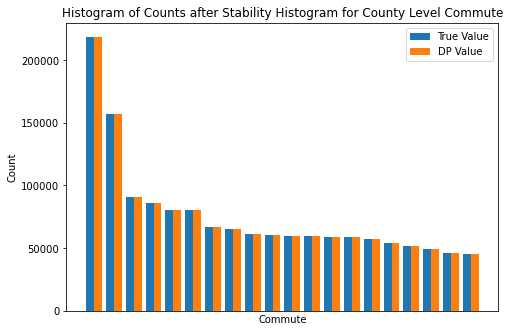

In [226]:
plot_histogram(county_true_count_list[0:20], county_epsilon05_list[0:20])


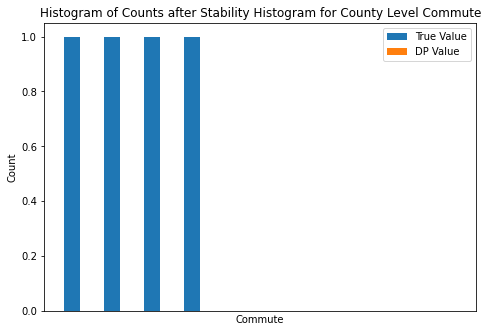

In [227]:
plot_histogram(county_true_count_list[1075:1085], county_epsilon05_list[1075:1085])

In [228]:
def plot_histogram(sensitive_counts, released_counts):
    """Plot a histogram that compares true data against released data"""
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    #plt.ylim([0,20000])
    
    #plt.xlim(0,1084)
    width = .4

    plt.bar(list([x+width for x in range(0, len(sensitive_counts))]), sensitive_counts, width=width, label='True Value')
    plt.bar(list([x+2*width for x in range(0, len(released_counts))]), released_counts, width=width, label='DP Value')

    plt.legend()
    plt.xticks([])  
    plt.title('Histogram of Counts after Stability Histogram for ED Level Commute')
    plt.xlabel('Commute')
    plt.ylabel('Count')
    plt.show()


In [229]:
ordered_ed_stability_dp_df = ed_stability_dp_df.sort_values(by=['True Count'], ascending=False)

In [230]:
ordered_ed_stability_dp_df

,ED Level Commute,True Count,Privacy 0.5,Privacy 1.0,Privacy 1.5,Privacy 2.0,Privacy 2.5,Privacy 3.0,Privacy 3.5,Privacy 4.0,Privacy 4.5,Privacy 5.0
2232509,Navan Rural-Navan Rural,5871,5863,5871,5873,5872,5869,5870,5871,5871,5871,5871
760350,Blanchardstown-Blakestown-Blanchardstown-Blake...,5768,5774,5766,5766,5769,5768,5768,5768,5769,5768,5768
1052065,Naas Urban-Naas Urban,5594,5596,5590,5592,5593,5594,5595,5594,5594,5594,5594
1146698,Maynooth-Maynooth,4477,4464,4477,4477,4474,4479,4478,4476,4477,4476,4477
3398546,Clenagh-Clenagh,4459,4456,4461,4460,4459,4461,4459,4460,4459,4458,4458
...,...,...,...,...,...,...,...,...,...,...,...,...
3020442,Fethard-Foxrock-Torquay,0,0,0,0,0,0,0,0,0,0,0
3020441,Fethard-Ballinteer-Marley,0,0,0,0,0,0,0,0,0,0,0
3020440,Fethard-Castlebar Rural,0,0,0,0,0,0,0,0,0,0,0
3020439,Fethard-Shantalla,0,0,0,0,0,0,0,0,0,0,0


In [243]:
ed_true_count_list = ordered_ed_stability_dp_df['True Count'].to_list()
ed_epsilon05_list = ordered_ed_stability_dp_df['Privacy 0.5'].to_list()
ed_epsilon25_list = ordered_ed_stability_dp_df['Privacy 2.5'].to_list()

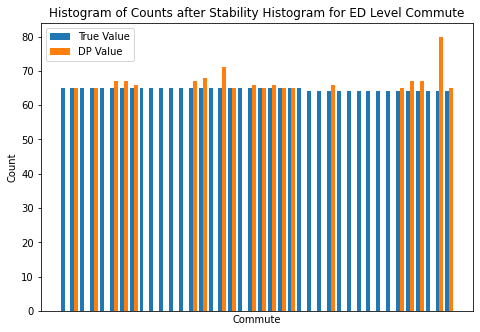

In [242]:
plot_histogram(ed_true_count_list[6970:7010], ed_epsilon05_list[6970:7010])


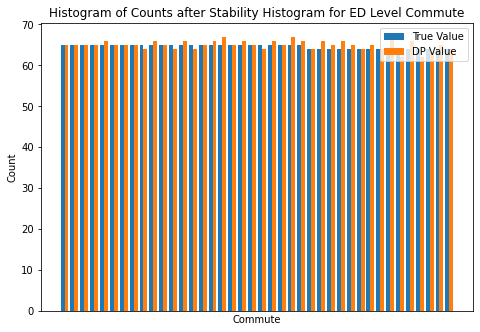

In [244]:
plot_histogram(ed_true_count_list[6970:7010], ed_epsilon25_list[6970:7010])

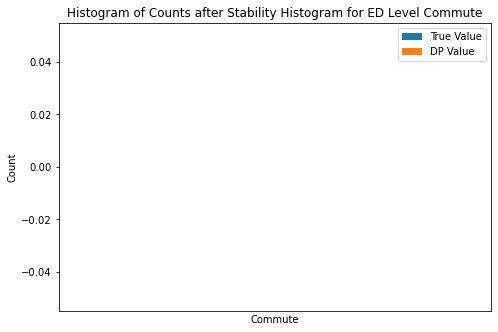

In [233]:
plot_histogram(ed_true_count_list[8699638:8699658], ed_epsilon05_list[8699638:8699658])


In [235]:
#Number of non zero commutes for privacy budget 0.5
len(ed_epsilon05_list) - ed_epsilon05_list.count(0)

8692648

In [245]:
#Number of non zero commutes for privacy budget 2.5
len(ed_epsilon05_list) - ed_epsilon25_list.count(0)

35954

In [237]:
8699658 - 8692648

7010

In [ ]:
ed_epsilon05_list.count(0)

In [247]:
ed_stability_dp_df.sort_values(by=['True Count'], ascending=False).head(15)

,ED Level Commute,True Count,Privacy 0.5,Privacy 1.0,Privacy 1.5,Privacy 2.0,Privacy 2.5,Privacy 3.0,Privacy 3.5,Privacy 4.0,Privacy 4.5,Privacy 5.0
2232509,Navan Rural-Navan Rural,5871,5863,5871,5873,5872,5869,5870,5871,5871,5871,5871
760350,Blanchardstown-Blakestown-Blanchardstown-Blake...,5768,5774,5766,5766,5769,5768,5768,5768,5769,5768,5768
1052065,Naas Urban-Naas Urban,5594,5596,5590,5592,5593,5594,5595,5594,5594,5594,5594
1146698,Maynooth-Maynooth,4477,4464,4477,4477,4474,4479,4478,4476,4477,4476,4477
3398546,Clenagh-Clenagh,4459,4456,4461,4460,4459,4461,4459,4460,4459,4458,4458
5380057,Ballycummin-Ballycummin,4144,4142,4144,4140,4145,4145,4145,4144,4144,4144,4145
4130816,Ballincollig-Ballincollig,3971,3974,3974,3972,3970,3971,3971,3971,3971,3971,3971
5382491,Ballysimon-Ballysimon,3732,3735,3735,3733,3733,3732,3732,3733,3732,3732,3732
5149552,Tralee Rural-Tralee Urban,3686,3686,3688,3687,3685,3686,3686,3684,3686,3686,3686
4150198,Carrigaline-Carrigaline,3420,3420,3422,3423,3418,3422,3420,3421,3420,3420,3420
